In [1]:
# this notebooks reproduces some examples in <http://people.csail.mit.edu/torralba/code/spatialenvelope/>


In [2]:
%matplotlib inline
from __future__ import print_function, absolute_import, division
from early_vision_toolbox import gist
from early_vision_toolbox import root_path
import matplotlib.pyplot as plt
from skimage.io import imread
import os.path
from subprocess import check_output
from numpy.linalg import norm
import numpy as np
from early_vision_toolbox.util import grouper
from sklearn.cross_validation import StratifiedKFold, cross_val_score, StratifiedShuffleSplit
from sklearn.svm import SVC

root dir at /mnt/temp_drive_2/zym1010/early-vision-toolbox/early_vision_toolbox


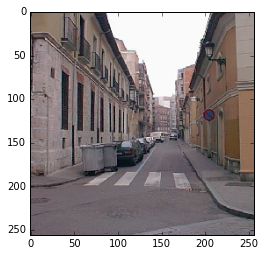

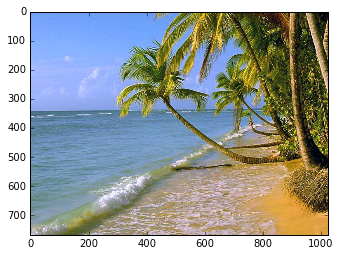

In [3]:
img1 = imread(os.path.join(root_path, 'gist', 'matlab', 'demo1.jpg'))
img2 = imread(os.path.join(root_path, 'gist', 'matlab', 'demo2.jpg'))
plt.close('all')
plt.imshow(img1)
plt.show()
plt.close('all')
plt.imshow(img2)
plt.show()

In [4]:
# now time to compute their gist features.
a=gist.get_gist([img1, img2])

saving input mat to /tmp/tmp8rMJp3.mat
saving done.
matlab -nodesktop -nosplash -nodisplay -r try;cd('/tmp');tmpvyPLg1;catch ME;disp(ME);exit(1);end;disp('done calling!');exit;


In [5]:
norm(a[0]),norm(a[1]),norm(a[0]-a[1])
# this result should be very similar to what you get when running `demoGist_simple.m`
# the difference is due to difference in jpeg loading. 

(1.159548, 0.98542845, 0.87086469)

In [6]:
# now run the reference matlab program

In [7]:
matlab_ref_result = check_output(['matlab', '-r', 'demoGist_simple; exit;'], cwd=os.path.join(root_path, 'gist', 'matlab'))

In [8]:
print(matlab_ref_result)

MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2015 The MathWorks, Inc.
                   R2015a (8.5.0.197613) 64-bit (glnxa64)
                             February 12, 2015

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
gist1 norm: 1.160080, gist2 norm: 0.986886, diff norm :0.872333



In [9]:
# ok. now time to try computing all gist features for that spatial envelop dataset, and then classify them using a SVM.
# load the dataset, getting labels and image names.
spatial_envelop_dataset_root = '/home/leelab_share/datasets/spatial_envelope/spatial_envelope_256x256_static_8outdoorcategories/'
list_of_files = [x for x in os.listdir(spatial_envelop_dataset_root) if x.endswith('.jpg')]
y = [x[:x.index('_')] for x in list_of_files]
y = np.array(y)
assert np.unique(y).size == 8

In [10]:
images_this = [imread(os.path.join(spatial_envelop_dataset_root,x)) for x in list_of_files]
X = gist.get_gist(images_this)

saving input mat to /tmp/tmpHLGqGd.mat
saving done.
matlab -nodesktop -nosplash -nodisplay -r try;cd('/tmp');tmp9cAiq3;catch ME;disp(ME);exit(1);end;disp('done calling!');exit;


In [11]:
X.shape
print(abs(X).mean(), abs(X).std())

0.0458945 0.0316147


In [12]:
# create splits. here I do a 3 fold stratified, roughly matching 100 from each class as described in the web page.
# well actually here I'm using 200 from each class. to be really correct, I need to use StratifiedShuffleSplit,
# which is buggy in sklearn 0.18.1... but I don't think this size is a big concern, 100 or 200 should not make much
# a difference. (maybe just 2, or 3 percent, or something like that).
split_obj = StratifiedKFold(y, n_folds=3)
for train, test in split_obj:
    print('train {}, test {}'.format(len(train), len(test)))
avg_score = cross_val_score(SVC(C=250, kernel='rbf', random_state=0),X=X,y=y,cv=split_obj)
print(avg_score)
# this score (around 0.83) should match that in the website (83.7%)
# C can make huge difference.
# well maybe this has something to do with data normalization. whatever.
# looks that people also tried large C as well, as in
# <http://stackoverflow.com/questions/26337403/what-is-a-good-range-of-values-for-the-svm-svc-hyperparameters-to-be-explored>
avg_score = cross_val_score(SVC(C=1, kernel='rbf', random_state=0),X=X,y=y,cv=split_obj)
print(avg_score)

train 1789, test 899
train 1791, test 897
train 1796, test 892
[ 0.82313682  0.83835006  0.83408072]
[ 0.15239155  0.15273133  0.15246637]
